# Split Optimization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sys
import os
myDir = os.path.join(os.getcwd(), '../..')
sys.path.append(myDir)
addDir = os.path.join(os.getcwd(), '../../../..')
sys.path.append(addDir)
import eaopack as eao

In [2]:
def plot_results(portfolio, op, res, prices, num_imgs_per_row=2):
    out = eao.io.extract_output(portfolio, op, res, prices)
    num_nodes = len(portfolio.nodes)
    num_img_rows=int(np.ceil((num_nodes+2)/num_imgs_per_row))
    fig, ax = plt.subplots(num_img_rows, num_imgs_per_row, tight_layout = True, figsize=(18,5*num_img_rows))
    ax = ax.reshape(-1)

    # Plot the dispatch for each node:
    current_ax=0
    dispatch_per_node = {node: [] for node in portfolio.nodes}
    for mycol in out['dispatch'].columns.values:
        for node in dispatch_per_node:
            if '(' + node + ')' in mycol:
                dispatch_per_node[node].append(mycol)
    for node in dispatch_per_node:
        out['dispatch'][dispatch_per_node[node]].plot(ax=ax[current_ax], style='-x')
        ax[current_ax].set_title("Dispatch " + node)
        current_ax+=1

    # Plot internal variables:
    for v in out['internal_variables']:
        out['internal_variables'][v].plot(ax=ax[current_ax], style='-x', label=v)
    if out['internal_variables'].shape[1] == 0:
        ax[current_ax].text(0.4, 0.5, "No bool variables present")
    ax[current_ax].set_title('Bool Variables')
    ax[current_ax].legend()

    # Remove empty axes:
    for i in range(current_ax+1, len(ax)):
        fig.delaxes(ax[i])

## Portfolio Definition

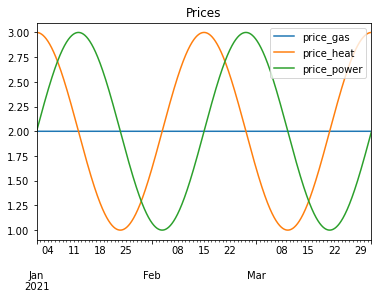

In [3]:
timegrid = eao.assets.Timegrid(dt.date(2021, 1, 1), dt.date(2021, 4, 1), freq='h', main_time_unit='h')

prices = {
    'price_gas': np.ones(timegrid.T)*2,
    'price_heat': np.cos(4*np.pi * np.arange(timegrid.T)/timegrid.T)+2,
    'price_power': np.sin(4*np.pi * np.arange(timegrid.T)/timegrid.T)+2,          
}

prices = timegrid.prices_to_grid(prices)

prices.plot(title="Prices")

node_power = eao.assets.Node('node_power')
node_heat = eao.assets.Node('node_heat')
node_gas = eao.assets.Node('node_gas')

simple_contract_power = eao.assets.SimpleContract(name='SC_power', price='price_power', nodes=node_power,
                                             min_cap=-30., max_cap=20)
simple_contract_heat = eao.assets.SimpleContract(name='SC_heat', price='price_heat', nodes=node_heat,
                                             min_cap=-30., max_cap=20.)
simple_contract_gas = eao.assets.SimpleContract(name='SC_gas', price='price_gas', nodes=node_gas,
                                             min_cap=-30., max_cap=20.)


chpasset = eao.assets.CHPAsset(name='CHP',
                               nodes=[node_power, node_heat, node_gas],
                               min_cap=5.,
                               max_cap=30.,
                               ramp=10)
portfolio = eao.portfolio.Portfolio([chpasset, simple_contract_power, simple_contract_heat, simple_contract_gas])

## Split Optimization

In [4]:
op_split = portfolio.setup_split_optim_problem(prices, timegrid, interval_size="1w")
res_split = op_split.optimize(solver="GLPK_MI")
print()

...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP


Value: 23393.663322608252


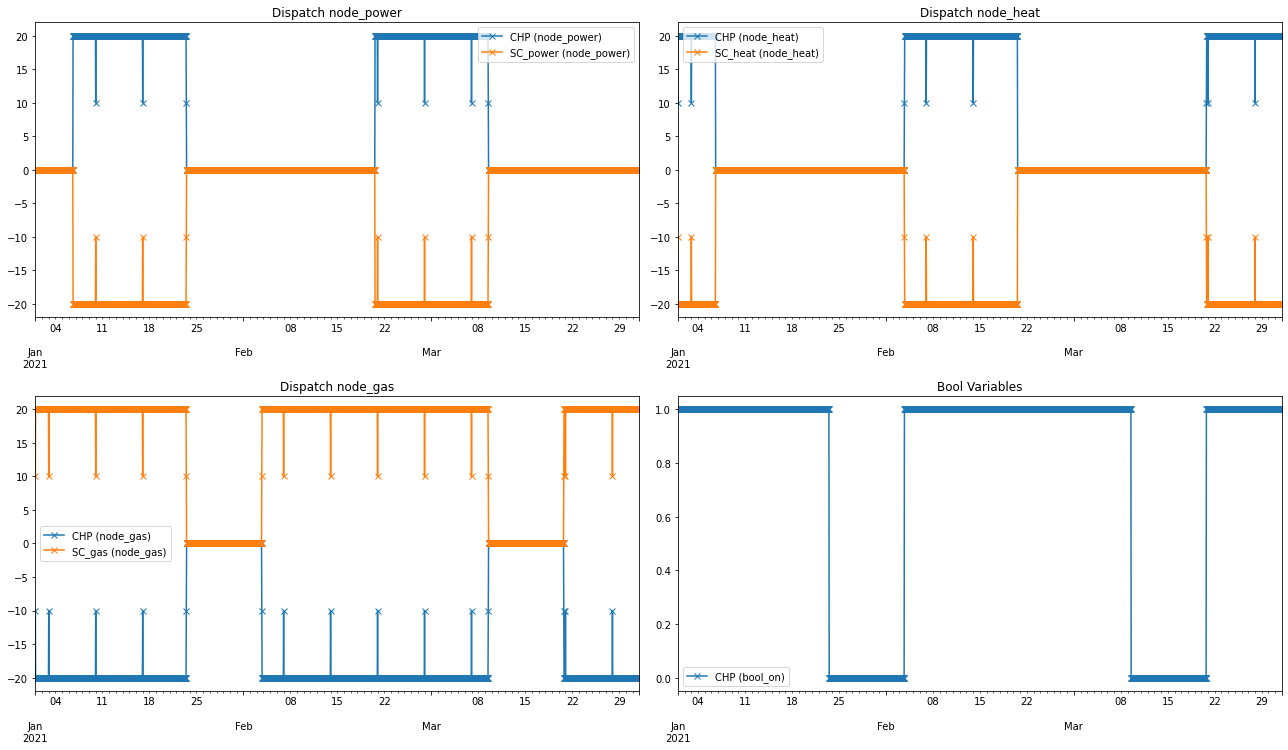

In [5]:
print("Value:", res_split.value)
plot_results(portfolio, op_split, res_split, prices)

## Full Optimization

In [6]:
op_full = portfolio.setup_optim_problem(prices, timegrid)
res_full = op_full.optimize(solver="GLPK_MI")

...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP


Value: 23464.337087301334


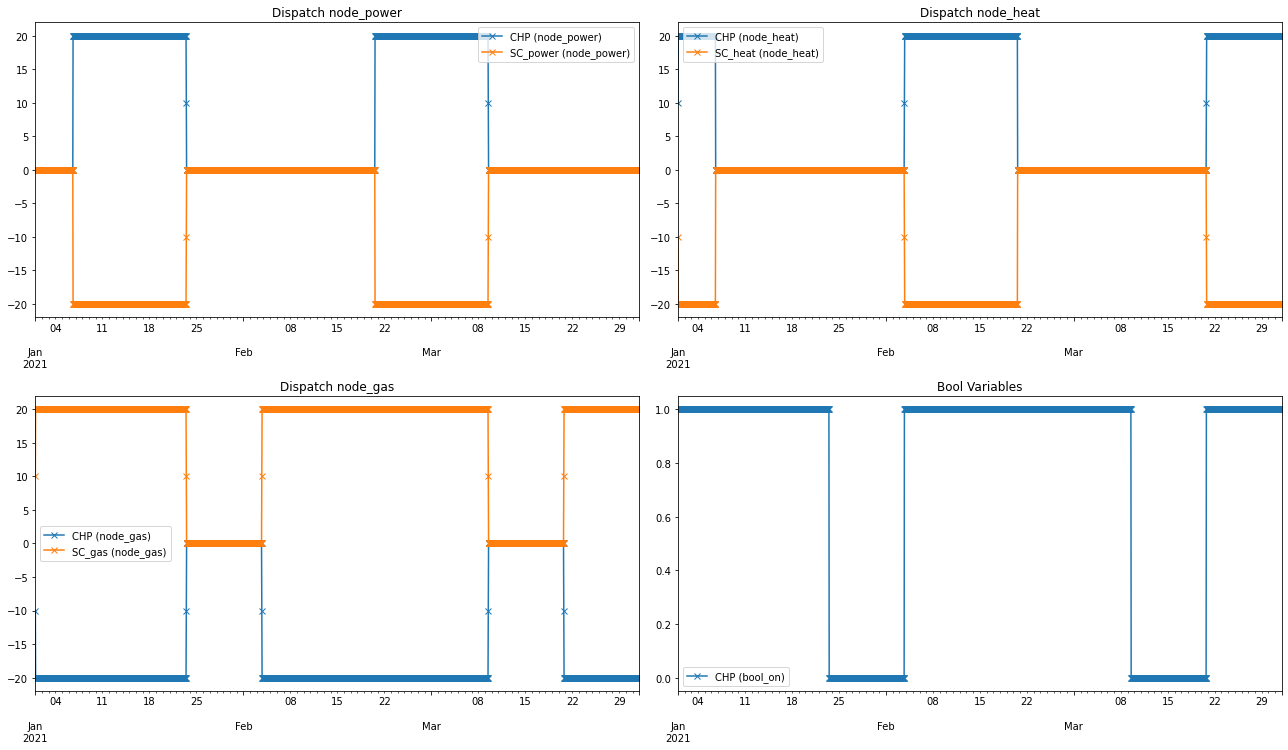

In [7]:
print("Value:", res_full.value)
plot_results(portfolio, op_full, res_full, prices)